In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
import seaborn as sns
import json

KOJI JE TIMEZONE ZA SVAKI OD SENZORA?

- Motion.csv: Funkcionira li labelanje 0 i 1 na isti nacin kao otvaranje vrata, npr ako je 15:00:10 1, te u 15:00:40 0, onda je tih 30 sekundi detektiran pokret? 
Pretpostavljam da je senzor postavljen unutar sobe da mainly prati prisutnost ljudi? Ako je tako, onda sljedeće pitanje, situacija u datasetu Motion.csv:
15/10/2024 08:09	1
15/10/2024 08:10	0
15/10/2024 08:10	1
15/10/2024 08:15	0
15/10/2024 08:15	1
15/10/2024 08:16	0
15/10/2024 08:16	1
15/10/2024 08:19	0
15/10/2024 08:19	1
15/10/2024 08:20	0
15/10/2024 08:20	1
15/10/2024 08:22	0
15/10/2024 08:23	1
15/10/2024 08:24	0
15/10/2024 08:24	1
15/10/2024 08:25	0
15/10/2024 08:25	1
15/10/2024 08:27	0
15/10/2024 08:27	1
15/10/2024 08:28	0
15/10/2024 08:28	1
15/10/2024 08:33	0
15/10/2024 08:33	1
15/10/2024 08:34	0
15/10/2024 08:36	1
15/10/2024 08:38	0
Ako je svrha senzora detekcija ljudi u sobi pretpostavljam da bi bilo najbolje zaključiti da je netko bio u sobi 08:09 - 08:38 i na taj način napraviti jedan kontinuirani label od pola sata? 
Ako pogledamo People.csv, u ovom vremenskom intervalu detektirana je osoba na sljedeći način:
15/10/2024 08:24	1
15/10/2024 08:25	0
15/10/2024 08:26	0
15/10/2024 08:27	0
15/10/2024 08:28	1
15/10/2024 08:29	0
15/10/2024 08:30	0
15/10/2024 08:31	1
15/10/2024 08:33	0
15/10/2024 08:34	0
15/10/2024 08:35	1
15/10/2024 08:36	0
Kada usporedimo ova dva intervala, dolazimo do zaključka da nije pametno zaključiti da je čovjek u sobi tih pola sata bazirano na motion.csv, kakav bi to onda mogao biti movement, mislim da nije prašina etc. zato što je previše consistently detectano, ili?


- Outdoor_sensor_provider_2 
Senzor za zrak vani, time delta 5 min, na koji nacin najbolje aproksimirati data između? Moja ideja linearnom funkcijom (lin. rast/pad)

- People.csv 
Detekcija broja ljudi u sobi (int). Kolko ja vidim senzor ne funkcionira na način da detecta promijene nego vrsi ocitanja svaku minutu, kako da onda fillam data između?

- Traffic_data, kako je ovo detectano, gdje je pozicionirano? Trebam bolje biti upoznat o detaljima da mogu doći sam do zaključka. Data tek od 22.10, jel ima smisla dodavati taj label ako nismo u vremenu prije, hoce li model doci do krivoh zakljucka?

## Data loading and preprocessing

### Original dataset with garden_door and hallway_door

In [62]:
# Load and preprocess door and window data
garden_door_df = pd.read_csv('datasets/Door_windows.csv')
garden_door_df = garden_door_df.drop('Door_balcony_1st_floor', axis=1)
garden_door_df = garden_door_df.drop('Door_Hallway', axis=1)
garden_door_df['Date'] = pd.to_datetime(garden_door_df['Date'], format='%d/%m/%Y %H:%M')
garden_door_df['Door_Garden'] = garden_door_df['Door_Garden'].map({'on': 1, 'off': 0})
garden_door_df = garden_door_df.drop_duplicates(subset='Date', keep='last')

# RESAMPLANJE U 1 SEKUNDU
garden_door_df.set_index('Date', inplace=True)
garden_door_df = garden_door_df.resample('1s').ffill()
garden_door_df.reset_index(inplace=True)
garden_door_df = garden_door_df.drop('Unnamed: 0', axis=1)
#garden_door_df.to_csv("datasets/garden_door_dataset.csv", index=False)

# Load and preprocess door and window data
hallway_door_df = pd.read_csv('datasets/Door_windows.csv')
hallway_door_df = hallway_door_df.drop('Door_balcony_1st_floor', axis=1)
hallway_door_df = hallway_door_df.drop('Door_Garden', axis=1)
hallway_door_df['Date'] = pd.to_datetime(hallway_door_df['Date'], format='%d/%m/%Y %H:%M')
hallway_door_df['Door_Hallway'] = hallway_door_df['Door_Hallway'].map({'on': 1, 'off': 0})
hallway_door_df = hallway_door_df.drop_duplicates(subset='Date', keep='last')

# RESAMPLANJE U 1 SEKUNDU
hallway_door_df.set_index('Date', inplace=True)
hallway_door_df = hallway_door_df.resample('1s').ffill()
hallway_door_df.reset_index(inplace=True)
hallway_door_df = hallway_door_df.drop('Unnamed: 0', axis=1)
#garden_door_df.to_csv("datasets/garden_door_dataset.csv", index=False)

sensor_df = pd.read_csv('datasets/LS0623020168.csv')
# Convert UTC to UTC+2
sensor_df['timestamp(ZG)'] = pd.to_datetime(sensor_df['timestamp(UTC)']) + timedelta(hours=2)

# Handling daylight savings ZG: (UTC+2) -> (UTC+1)
dst_cutoff = pd.Timestamp('2024-10-27 03:00:00')
sensor_df['timestamp(ZG)'] = sensor_df['timestamp(ZG)'].apply(
    lambda x: x - timedelta(hours=1) if x >= dst_cutoff else x
)

merged_df = pd.merge(sensor_df, garden_door_df[["Date", "Door_Garden"]],
                     left_on="timestamp(ZG)", right_on="Date", how="left")
merged_df = pd.merge(merged_df, hallway_door_df[["Date", "Door_Hallway"]],
                     left_on="timestamp(ZG)", right_on="Date", how="left")
merged_df = merged_df.drop(columns=["Date_x", "Date_y"])
merged_df = merged_df[merged_df["timestamp(ZG)"] >= garden_door_df['Date'].min()]

# Dropping duplicated values of timestamp resulted in moving the clock by 1 hour
merged_df = merged_df.drop_duplicates(subset='timestamp(ZG)', keep='first')

#merged_df.to_csv("datasets/merged_sensor_data.csv", index=False)

### Filtering out times of experiments being done (except door_opened)

In [63]:
with open("datasets/experiments.json", "r") as file:
    experiment_data = json.load(file)

# Convert the experiment intervals into a DataFrame
intervals = []
for experiment, times in experiment_data["experiments"].items():
    for time_range in times:
        intervals.append({"start": pd.to_datetime(time_range[0]), "end": pd.to_datetime(time_range[1])})
intervals = intervals[1:]   # OSTAVLJAMO DOOR OPENING
intervals_df = pd.DataFrame(intervals)

# Filter out rows within the intervals
for _, row in intervals_df.iterrows():
    merged_df = merged_df[
        ~((merged_df['timestamp(ZG)'] >= row['start']) & (merged_df['timestamp(ZG)'] <= row['end']))
    ]
    
merged_df = merged_df.dropna()
#merged_df.to_csv("datasets/merged_sensor_data_no_experiments.csv", index=False)

### Filtering out (removing) when hallway doors are opened by themselves

In [64]:
merged_df = merged_df[~((merged_df['Door_Hallway'] == 1) & (merged_df['Door_Garden'] == 0))]

#### We should add a % of filtered out data, should not be over 10%

## Visualizing the data

In [65]:
# Visualizing the whole dataset
"""
# Set up a figure for the subplots
fig, axs = plt.subplots(8, 2, figsize=(15, 30))
fig.suptitle('Time series of paramaters', fontsize=16)

# List of parameters and titles
parameters = [
    ('NetCO2-CO2(ppm)', 'NetCO2-CO2 (ppm)'),
    ('NetCO2-CO2_ug', 'NetCO2-CO2 (µg)'),
    ('NetADC_O3-O3_ug', 'NetADC_O3-O3 (µg)'),
    ('NetADC_O3-O3(ppb)', 'NetADC_O3-O3 (ppb)'),
    ('NetADC_CO-CO_ug', 'NetADC_CO-CO (µg)'),
    ('NetADC_CO-CO( ppb)', 'NetADC_CO-CO (ppb)'),
    ('NetPM-PM10(µg/m3)', 'NetPM-PM10 (µg/m³)'),
    ('NetPM-PM25(µg/m3)', 'NetPM-PM25 (µg/m³)'),
    ('NetPid_P1-PPB(ppm)', 'NetPid_P1-PPB (ppm)'),
    ('NetPid_P1-PPB_ug', 'NetPid_P1-PPB (µg)'),
    ('NetBME280-PERC(%)', 'NetBME280 Humidity (%)'),
    ('NetBME280-TEMP_EXT(°C)', 'NetBME280 Temperature (°C)'),
    ('NetBME280-HPA(hPa)', 'NetBME280 Pressure (hPa)'),
    ('NetADC_NO2-NO2_ug', 'NetADC_NO2-NO2 (µg)'),
    ('NetADC_NO2-NO2(ppb)', 'NetADC_NO2-NO2 (ppb)')
]

# Plot each parameter in a separate subplot
for i, (param, title) in enumerate(parameters):
    row, col = divmod(i, 2)
    axs[row, col].plot(sensor_df['timestamp(ZG)'], sensor_df[param])
    axs[row, col].set_title(title)
    axs[row, col].set_xlabel('Time')
    axs[row, col].set_ylabel(title)
    axs[row, col].tick_params(axis='x', rotation=45)

axs[7,1].plot(merged_df['timestamp(ZG)'],merged_df['any_door_open'])
axs[7,1].set_title('Any door open')
axs[7,1].set_xlabel('Time')
axs[7,1].set_ylabel('Yes (1), No (0)')
axs[7,1].tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title
plt.show()
"""

"\n# Set up a figure for the subplots\nfig, axs = plt.subplots(8, 2, figsize=(15, 30))\nfig.suptitle('Time series of paramaters', fontsize=16)\n\n# List of parameters and titles\nparameters = [\n    ('NetCO2-CO2(ppm)', 'NetCO2-CO2 (ppm)'),\n    ('NetCO2-CO2_ug', 'NetCO2-CO2 (µg)'),\n    ('NetADC_O3-O3_ug', 'NetADC_O3-O3 (µg)'),\n    ('NetADC_O3-O3(ppb)', 'NetADC_O3-O3 (ppb)'),\n    ('NetADC_CO-CO_ug', 'NetADC_CO-CO (µg)'),\n    ('NetADC_CO-CO( ppb)', 'NetADC_CO-CO (ppb)'),\n    ('NetPM-PM10(µg/m3)', 'NetPM-PM10 (µg/m³)'),\n    ('NetPM-PM25(µg/m3)', 'NetPM-PM25 (µg/m³)'),\n    ('NetPid_P1-PPB(ppm)', 'NetPid_P1-PPB (ppm)'),\n    ('NetPid_P1-PPB_ug', 'NetPid_P1-PPB (µg)'),\n    ('NetBME280-PERC(%)', 'NetBME280 Humidity (%)'),\n    ('NetBME280-TEMP_EXT(°C)', 'NetBME280 Temperature (°C)'),\n    ('NetBME280-HPA(hPa)', 'NetBME280 Pressure (hPa)'),\n    ('NetADC_NO2-NO2_ug', 'NetADC_NO2-NO2 (µg)'),\n    ('NetADC_NO2-NO2(ppb)', 'NetADC_NO2-NO2 (ppb)')\n]\n\n# Plot each parameter in a separate s

For visualizing door opening, the data is reduced from 5s to 1m readings, the sensor data is the average value in that 1 minute, each day is saved as image in daily_plots

In [66]:
"""# Generating images by days
import os

parameters = [
    #('NetCO2-CO2(ppm)', 'NetCO2-CO2 (ppm)'),
    ('NetCO2-CO2_ug', 'NetCO2-CO2 (µg)'),
    ('NetADC_O3-O3_ug', 'NetADC_O3-O3 (µg)'),
    #('NetADC_O3-O3(ppb)', 'NetADC_O3-O3 (ppb)'),
    ('NetADC_CO-CO_ug', 'NetADC_CO-CO (µg)'),
    #('NetADC_CO-CO( ppb)', 'NetADC_CO-CO (ppb)'),
    ('NetPM-PM10(µg/m3)', 'NetPM-PM10 (µg/m³)'),
    ('NetPM-PM25(µg/m3)', 'NetPM-PM25 (µg/m³)'),
    #('NetPid_P1-PPB(ppm)', 'NetPid_P1-PPB (ppm)'),
    ('NetPid_P1-PPB_ug', 'NetPid_P1-PPB (µg)'),
    ('NetBME280-PERC(%)', 'NetBME280 Humidity (%)'),
    ('NetBME280-TEMP_EXT(°C)', 'NetBME280 Temperature (°C)'),
    ('NetBME280-HPA(hPa)', 'NetBME280 Pressure (hPa)'),
    ('NetADC_NO2-NO2_ug', 'NetADC_NO2-NO2 (µg)'),
    ('NetADC_NO2-NO2(ppb)', 'NetADC_NO2-NO2 (ppb)')
]

merged_df = merged_df.drop('timestamp(UTC)', axis=1)

# Set the UTC+1 timestamp as the index
merged_df.set_index('timestamp(ZG)', inplace=True)

# Resample the data to 1-minute intervals and calculate the mean
data_resampled = merged_df.resample('1min').mean()

# Reset the index to make 'timestamp(ZG)' a column again
data_resampled = data_resampled.reset_index()

# Ensure the directory for saving plots exists
output_dir = "daily_plots_no_hallway"
os.makedirs(output_dir, exist_ok=True)

# Loop through each unique day in the dataset
data_resampled['date'] = data_resampled['timestamp(ZG)'].dt.date
unique_days = data_resampled['date'].unique()

for day in unique_days:
    # Filter data for the specific day
    day_data = data_resampled[data_resampled['date'] == day]
    open_door_times = day_data[day_data['Door_Garden'] == 1]['timestamp(ZG)']
    
    # Set up a figure for the subplots
    fig, axs = plt.subplots(8, 2, figsize=(15, 22))
    fig.suptitle(
        f'Time series of parameters for {day}, red line = garden door open, blue line = hallway door open', 
        fontsize=16
    )
    
    # Plot each parameter in a separate subplot
    for i, (param, title) in enumerate(parameters):
        row, col = divmod(i, 2)
        axs[row, col].plot(day_data['timestamp(ZG)'], day_data[param])
        axs[row, col].set_title(title)
        axs[row, col].set_xlabel('Time')
        axs[row, col].set_ylabel(title)
        axs[row, col].tick_params(axis='x', rotation=45)
        
        # Add vertical lines for door open times with color
        for open_time in open_door_times:
            open_time_door_data = day_data[day_data['timestamp(ZG)'] == open_time]
            if (open_time_door_data['Door_Garden'].values == 1):
                axs[row, col].axvline(x=open_time, color='red', lw=1, alpha=0.2)
    
    # Remove unused subplots if they exist
    for j in range(len(parameters), len(axs.flatten())):
        fig.delaxes(axs.flatten()[j])
    
    # Adjust layout and save the plot
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title
    plt.savefig(os.path.join(output_dir, f'{day}.png'))
    plt.close(fig)"""

'# Generating images by days\nimport os\n\nparameters = [\n    #(\'NetCO2-CO2(ppm)\', \'NetCO2-CO2 (ppm)\'),\n    (\'NetCO2-CO2_ug\', \'NetCO2-CO2 (µg)\'),\n    (\'NetADC_O3-O3_ug\', \'NetADC_O3-O3 (µg)\'),\n    #(\'NetADC_O3-O3(ppb)\', \'NetADC_O3-O3 (ppb)\'),\n    (\'NetADC_CO-CO_ug\', \'NetADC_CO-CO (µg)\'),\n    #(\'NetADC_CO-CO( ppb)\', \'NetADC_CO-CO (ppb)\'),\n    (\'NetPM-PM10(µg/m3)\', \'NetPM-PM10 (µg/m³)\'),\n    (\'NetPM-PM25(µg/m3)\', \'NetPM-PM25 (µg/m³)\'),\n    #(\'NetPid_P1-PPB(ppm)\', \'NetPid_P1-PPB (ppm)\'),\n    (\'NetPid_P1-PPB_ug\', \'NetPid_P1-PPB (µg)\'),\n    (\'NetBME280-PERC(%)\', \'NetBME280 Humidity (%)\'),\n    (\'NetBME280-TEMP_EXT(°C)\', \'NetBME280 Temperature (°C)\'),\n    (\'NetBME280-HPA(hPa)\', \'NetBME280 Pressure (hPa)\'),\n    (\'NetADC_NO2-NO2_ug\', \'NetADC_NO2-NO2 (µg)\'),\n    (\'NetADC_NO2-NO2(ppb)\', \'NetADC_NO2-NO2 (ppb)\')\n]\n\nmerged_df = merged_df.drop(\'timestamp(UTC)\', axis=1)\n\n# Set the UTC+1 timestamp as the index\nmerged_df.s

## Data normalization

In [67]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

parameters_to_normalize = [
    'NetCO2-CO2(ppm)', 'NetCO2-CO2_ug', 'NetADC_O3-O3_ug',
    'NetADC_O3-O3(ppb)', 'NetADC_CO-CO_ug', 'NetADC_CO-CO( ppb)',
    'NetPM-PM10(µg/m3)', 'NetPM-PM25(µg/m3)', 'NetPid_P1-PPB(ppm)',
    'NetPid_P1-PPB_ug', 'NetBME280-PERC(%)', 'NetBME280-TEMP_EXT(°C)',
    'NetBME280-HPA(hPa)', 'NetADC_NO2-NO2_ug', 'NetADC_NO2-NO2(ppb)'
]

#scaler = MinMaxScaler()  # Use StandardScaler() for Z-score normalization
scaler = StandardScaler()
sensor_df_normalized = merged_df.copy()
sensor_df_normalized[parameters_to_normalize] = scaler.fit_transform(merged_df[parameters_to_normalize])

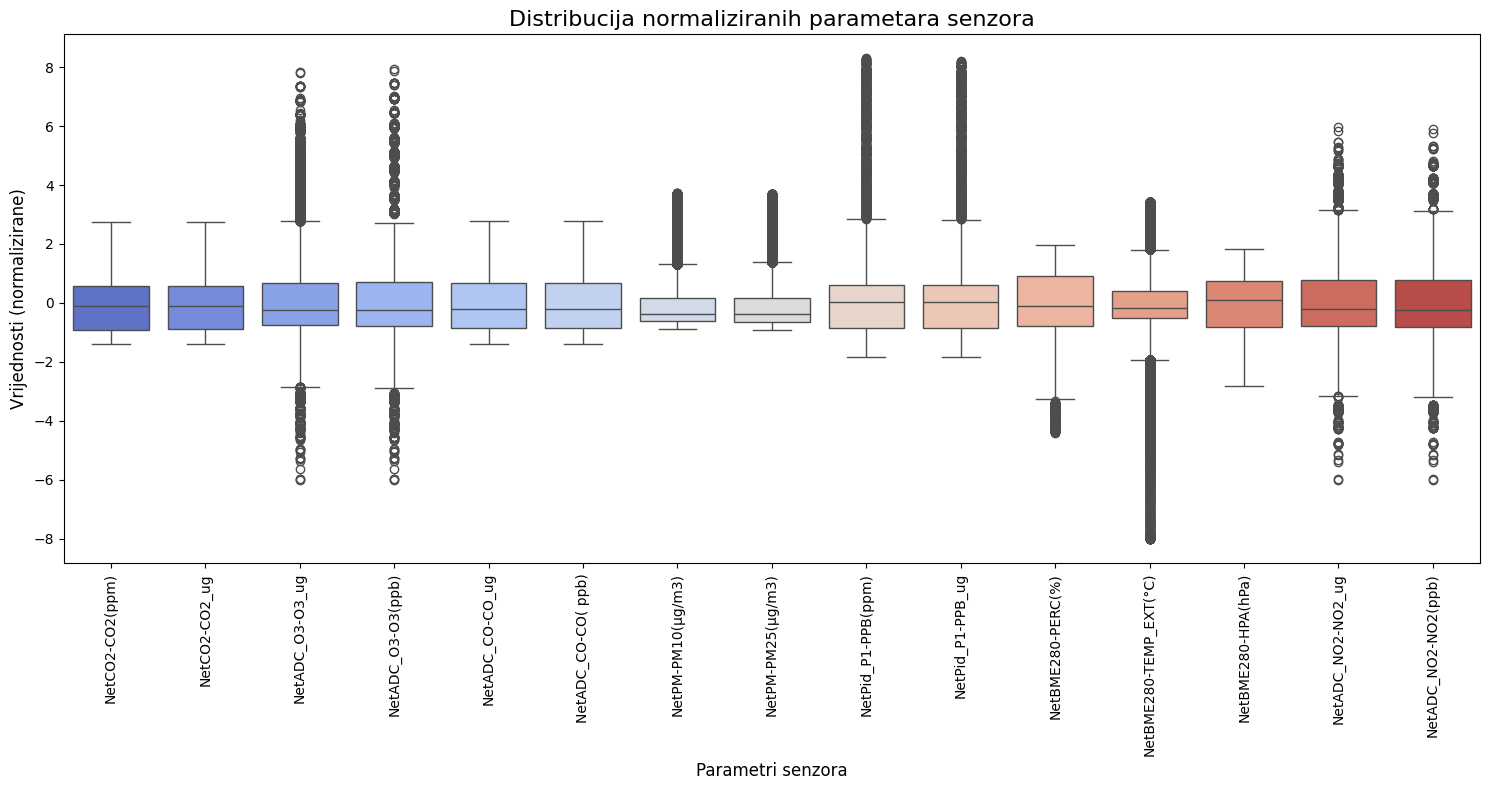

In [68]:
data_to_plot = sensor_df_normalized[parameters_to_normalize]

plt.figure(figsize=(15, 8))  # Set the figure size
sns.boxplot(data=data_to_plot, orient='v', palette='coolwarm')

plt.title('Distribucija normaliziranih parametara senzora', fontsize=16)  # Plot title in Croatian
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.xlabel('Parametri senzora', fontsize=12)
plt.ylabel('Vrijednosti (normalizirane)', fontsize=12)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

Correlation matrix with normalized data is the same as the corr. matrix with un-normalized data

## PCA Analysis

In [69]:
from sklearn.decomposition import PCA

parameters_for_PCA = [
    'NetCO2-CO2_ug', 'NetADC_O3-O3_ug', 'NetADC_CO-CO_ug',
    'NetPM-PM10(µg/m3)', 'NetPM-PM25(µg/m3)', 'NetPid_P1-PPB_ug', 'NetBME280-PERC(%)', 
    'NetBME280-TEMP_EXT(°C)', 'NetBME280-HPA(hPa)', 'NetADC_NO2-NO2_ug'
]

pca = PCA(n_components=10)
X_pca = pca.fit_transform(sensor_df_normalized[parameters_for_PCA])

In [70]:
pca_unnormalized = PCA(n_components=10)
X_pca_unnormalized = pca_unnormalized.fit_transform(merged_df[parameters_for_PCA])

### Scree plot

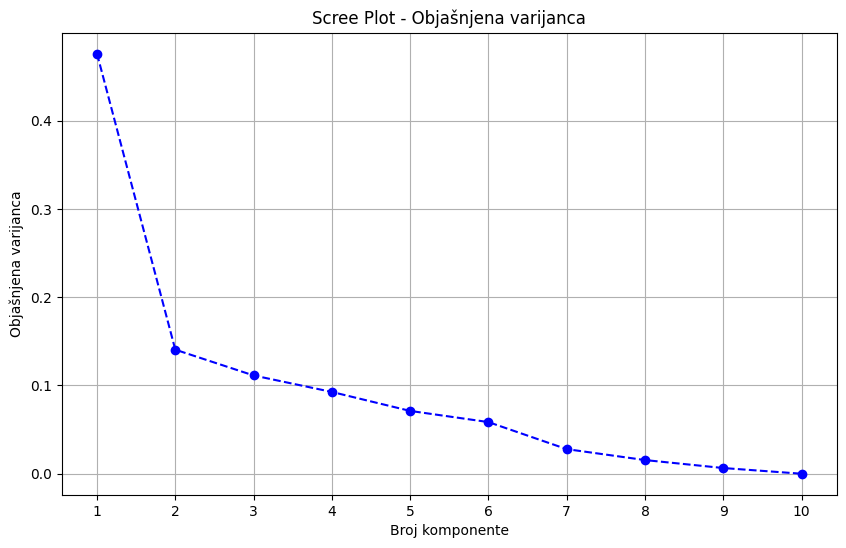

In [71]:
# Visualize explained variance ratio
plt.figure(figsize=(10, 6))
components = np.arange(1, len(pca.explained_variance_ratio_) + 1)  # Component indices
plt.plot(components, pca.explained_variance_ratio_, marker='o', linestyle='--', color='b')
plt.title('Scree Plot - Objašnjena varijanca')
plt.xlabel('Broj komponente')
plt.ylabel('Objašnjena varijanca')
plt.xticks(components)
plt.grid()
plt.show()


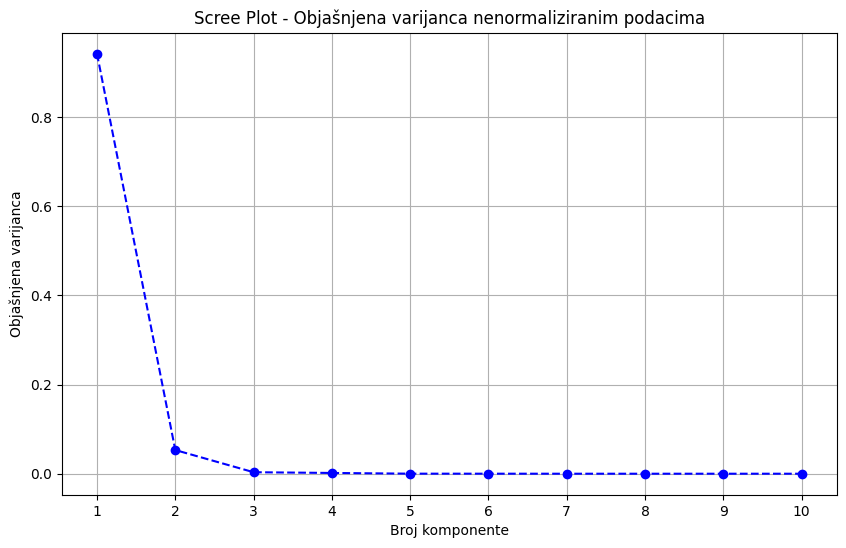

In [72]:
# Visualize explained variance ratio
plt.figure(figsize=(10, 6))
unnormalized_components = np.arange(1, len(pca_unnormalized.explained_variance_ratio_) + 1)  # Component indices
plt.plot(unnormalized_components, pca_unnormalized.explained_variance_ratio_, marker='o', linestyle='--', color='b')
plt.title('Scree Plot - Objašnjena varijanca nenormaliziranim podacima')
plt.xlabel('Broj komponente')
plt.ylabel('Objašnjena varijanca')
plt.xticks(unnormalized_components)  # Ensure all components are shown on x-axis
plt.grid()
plt.show()

### Cumulative Explained Variance

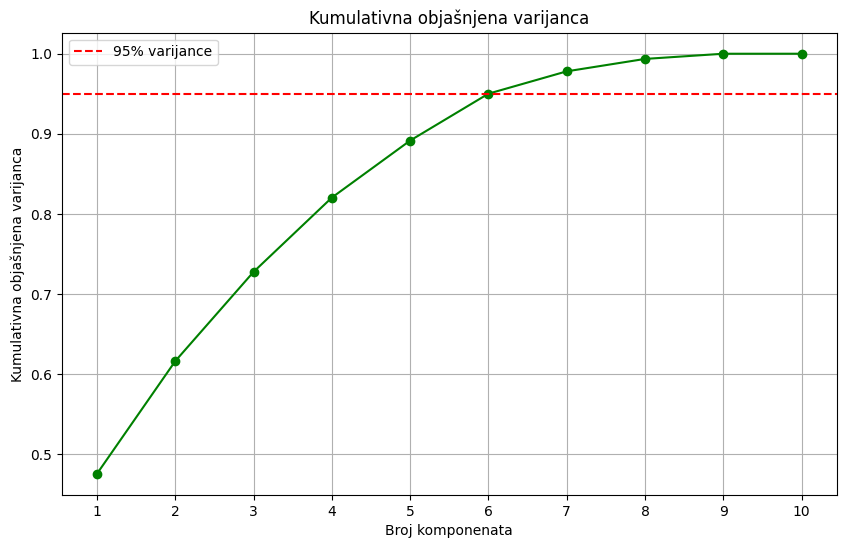

In [73]:
# Cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.plot(components, cumulative_variance, marker='o', linestyle='-', color='g')
plt.title('Kumulativna objašnjena varijanca')
plt.xlabel('Broj komponenata')
plt.ylabel('Kumulativna objašnjena varijanca')
plt.xticks(components)
plt.grid()

# Add a threshold line (e.g., 95% variance explained)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% varijance')
plt.legend()
plt.show()


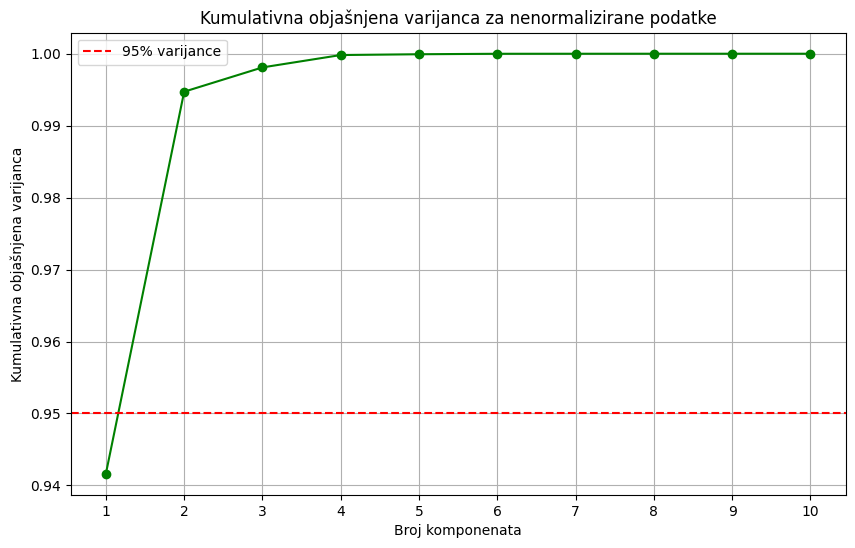

In [74]:
# Cumulative explained variance
unnormalized_cumulative_variance = np.cumsum(pca_unnormalized.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.plot(unnormalized_components, unnormalized_cumulative_variance, marker='o', linestyle='-', color='g')
plt.title('Kumulativna objašnjena varijanca za nenormalizirane podatke')
plt.xlabel('Broj komponenata')
plt.ylabel('Kumulativna objašnjena varijanca')
plt.xticks(unnormalized_components)
plt.grid()

# Add a threshold line (e.g., 95% variance explained)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% varijance')
plt.legend()
plt.show()

### PCA Loadings (Feature Contribution)

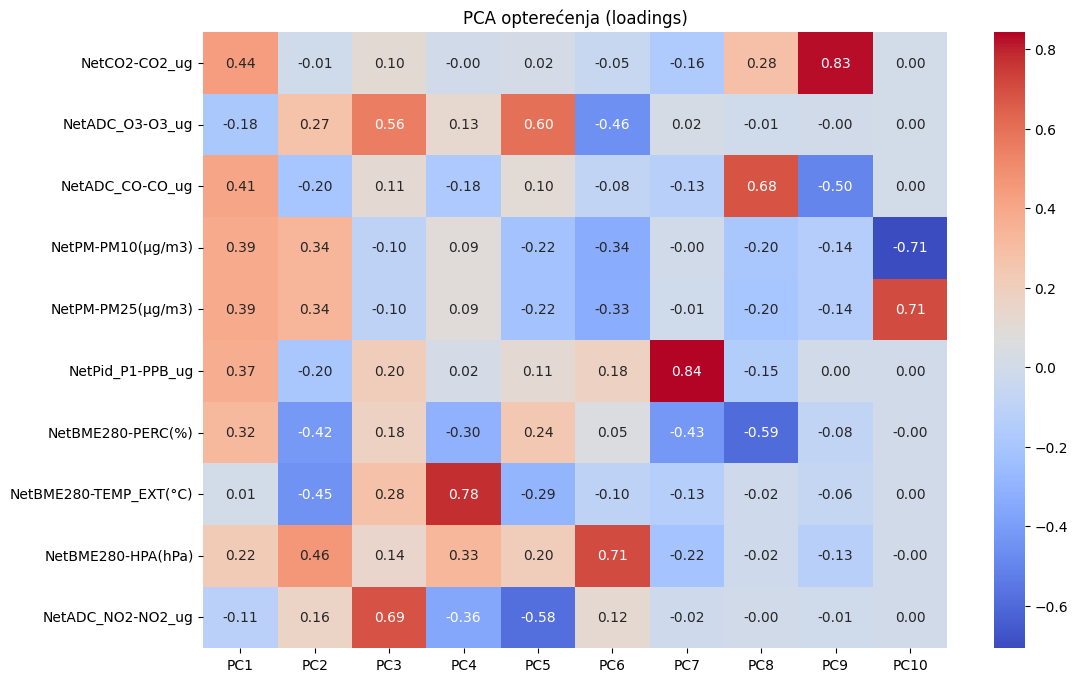

In [75]:
# Extract PCA components (loadings)
loadings = pca.components_.T  # Transpose to align with features
feature_names = parameters_for_PCA  # List of original feature names

# Create a DataFrame for loadings
loadings_df = pd.DataFrame(loadings, columns=[f'PC{i+1}' for i in range(loadings.shape[1])], index=feature_names)

# Plot heatmap for loadings
plt.figure(figsize=(12, 8))
sns.heatmap(loadings_df, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('PCA opterećenja (loadings)')
plt.show()


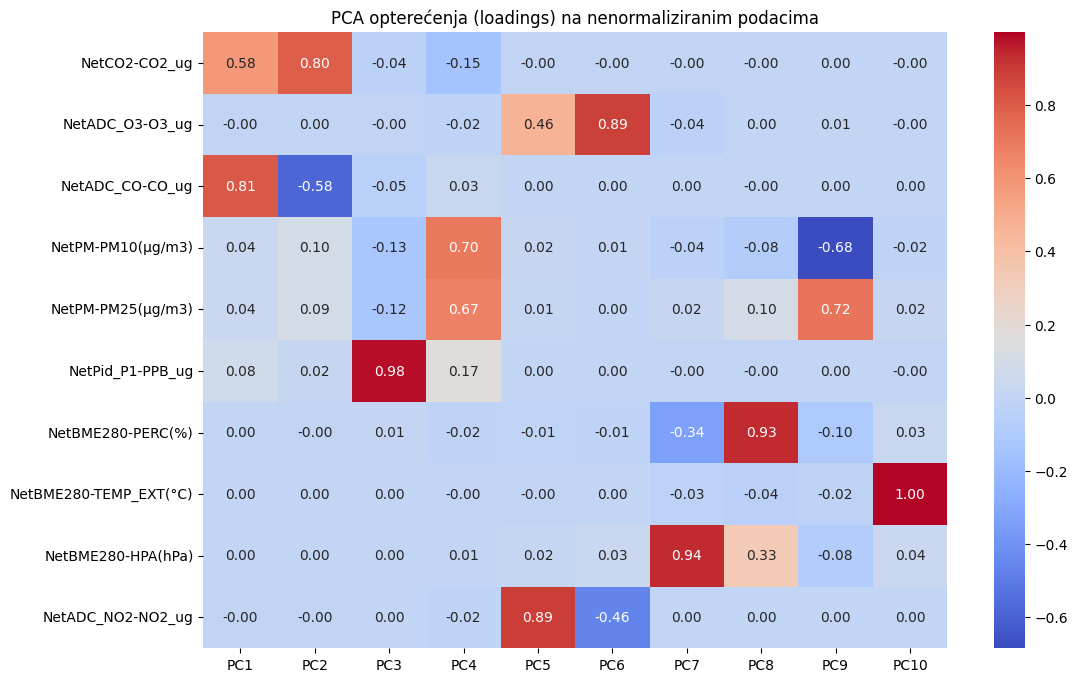

In [76]:
# Extract PCA components (loadings)
unnormalized_loadings = pca_unnormalized.components_.T  # Transpose to align with features
feature_names = parameters_for_PCA  # List of original feature names

# Create a DataFrame for loadings
unnormalized_loadings_df = pd.DataFrame(unnormalized_loadings, columns=[f'PC{i+1}' for i in range(unnormalized_loadings.shape[1])], index=feature_names)

# Plot heatmap for loadings
plt.figure(figsize=(12, 8))
sns.heatmap(unnormalized_loadings_df, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('PCA opterećenja (loadings) na nenormaliziranim podacima')
plt.show()


###


# MODELS


In [77]:
from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef
from sklearn.metrics import ConfusionMatrixDisplay

def evaluate_model(y_pred, y_test, name):
    cm = confusion_matrix(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    print("="*50)
    print(f"Results for {name}:")
    print(f"MCC: {mcc:.4f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix for {name}")
    plt.show()
    print("="*50)

## GRU

### GRU v1

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

#X = sensor_df_normalized[['NetADC_CO-CO_ug']].values
y = merged_df[['Door_Garden']].values
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, shuffle=False)

X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

model = Sequential([
    GRU(16, activation='tanh', return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    Dense(8, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # For binary classification
])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    verbose=1, 
    callbacks=[early_stopping]
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Make predictions
y_pred_prob = model.predict(X_test)

Best MCC: 0.7784 at Threshold: 0.00338
Results for GRU v2:
MCC: 0.7784
Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     58417
         1.0       0.82      0.75      0.78      1752

    accuracy                           0.99     60169
   macro avg       0.91      0.87      0.89     60169
weighted avg       0.99      0.99      0.99     60169

Confusion Matrix:



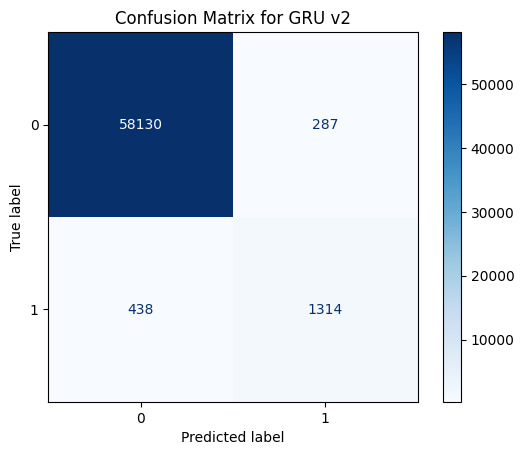

In [103]:
# 0.1  = MCC 0.504, experiments removed
# 0.1 = MCC 0.57, experiments, door_hallway removed
# 0.00338 = MCC 0.7784, experiments, door_hallway removed

best_mcc = -1  # MCC ranges from -1 to 1
best_threshold = 0

for threshold in np.arange(0, 0.01, 0.00001):
    # Binarize the predictions based on the threshold
    y_pred = (y_pred_prob > threshold).astype(int)
    
    mcc = matthews_corrcoef(y_test, y_pred)
    if mcc > best_mcc:
        best_mcc = mcc
        best_threshold = threshold

print(f"Best MCC: {best_mcc:.4f} at Threshold: {best_threshold}")
evaluate_model((y_pred_prob > best_threshold).astype(int), y_test, "GRU v2")